<a href="https://colab.research.google.com/github/anadimayank/Activation-Loss-Optimization/blob/master/wids2024_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install category_encoders
!pip install catboost

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import optuna
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder, OrdinalEncoder
from sklearn import set_config
import category_encoders
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer,StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

In [3]:
train = pd.read_csv(r'/content/training.csv', index_col='patient_id')
test = pd.read_csv(r'/content/test.csv', index_col='patient_id')
sub  = pd.read_csv(r'/content/sample_submission.csv')

In [4]:
train.head(3)

patient_race  payer_type patient_state  patient_zip3  patient_age  \
patient_id                                                                     
475714              NaN    MEDICAID            CA           924           84   
349367            White  COMMERCIAL            CA           928           62   
138632            White  COMMERCIAL            TX           760           43   

           patient_gender    bmi breast_cancer_diagnosis_code  \
patient_id                                                      
475714                  F    NaN                       C50919   
349367                  F  28.49                       C50411   
138632                  F  38.09                       C50112   

                                 breast_cancer_diagnosis_desc  \
patient_id                                                      
475714      Malignant neoplasm of unsp site of unspecified...   
349367      Malig neoplm of upper-outer quadrant of right ...   
138632      Malignant neoplasm of central portion of left ...   

           metastatic_cancer_diagnosis_code  ...   disabled    poverty  \
patient_id                                   ...                         
475714                                C7989  ...  12.871429  22.542857   
349367                                 C773  ...   8.957576  10.109091   
138632                                 C773  ...  11.253333   9.663333   

           limited_english commute_time  health_uninsured   veteran  \
patient_id                                                            
475714           10.100000    27.814286         11.200000  3.500000   
349367            8.057576    30.606061          7.018182  4.103030   
138632            3.356667    31.394915         15.066667  7.446667   

                Ozone      PM25        N02  DiagPeriodL90D  
patient_id                                                  
475714      52.237210  8.650555  18.606528               1  
349367      42.301121  8.487175  20.113179               1  
138632      40.108207  7.642753  14.839351               1  

[3 rows x 82 columns]

In [5]:
test.head(3)

patient_race  payer_type patient_state  patient_zip3  patient_age  \
patient_id                                                                     
573710            White    MEDICAID            IN           467           54   
593679              NaN  COMMERCIAL            FL           337           52   
184532         Hispanic    MEDICAID            CA           917           61   

           patient_gender  bmi breast_cancer_diagnosis_code  \
patient_id                                                    
573710                  F  NaN                       C50412   
593679                  F  NaN                       C50912   
184532                  F  NaN                       C50911   

                                 breast_cancer_diagnosis_desc  \
patient_id                                                      
573710      Malig neoplasm of upper-outer quadrant of left...   
593679      Malignant neoplasm of unspecified site of left...   
184532      Malignant neoplasm of unsp site of right femal...   

           metastatic_cancer_diagnosis_code  ...   hispanic   disabled  \
patient_id                                   ...                         
573710                                 C773  ...   3.564516  13.996774   
593679                                 C787  ...  10.261538  16.020513   
184532                                 C773  ...  47.726087   9.895652   

              poverty limited_english  commute_time  health_uninsured  \
patient_id                                                              
573710       7.985484        0.969355     24.955357         10.838710   
593679      13.602564        2.836842     23.952632         10.579487   
184532      10.515217       12.745652     32.530435          7.263043   

             veteran      Ozone      PM25        N02  
patient_id                                            
573710      8.080645  38.724876  7.947165  11.157161  
593679      9.302564  36.918257  7.838973  13.599985  
184532      3.810870  47.310325  9.595719  20.084231  

[3 rows x 81 columns]

In [6]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

In [7]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('DiagPeriodL90D')

In [8]:
num_cols

['patient_zip3',
 'patient_age',
 'bmi',
 'population',
 'density',
 'age_median',
 'age_under_10',
 'age_10_to_19',
 'age_20s',
 'age_30s',
 'age_40s',
 'age_50s',
 'age_60s',
 'age_70s',
 'age_over_80',
 'male',
 'female',
 'married',
 'divorced',
 'never_married',
 'widowed',
 'family_size',
 'family_dual_income',
 'income_household_median',
 'income_household_under_5',
 'income_household_5_to_10',
 'income_household_10_to_15',
 'income_household_15_to_20',
 'income_household_20_to_25',
 'income_household_25_to_35',
 'income_household_35_to_50',
 'income_household_50_to_75',
 'income_household_75_to_100',
 'income_household_100_to_150',
 'income_household_150_over',
 'income_household_six_figure',
 'income_individual_median',
 'home_ownership',
 'housing_units',
 'home_value',
 'rent_median',
 'rent_burden',
 'education_less_highschool',
 'education_highschool',
 'education_some_college',
 'education_bachelors',
 'education_graduate',
 'education_college_or_above',
 'education_stem_

In [9]:
cat_cols

['patient_race',
 'payer_type',
 'patient_state',
 'patient_gender',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'metastatic_first_novel_treatment',
 'metastatic_first_novel_treatment_type',
 'Region',
 'Division']

In [10]:
fig, ax = plt.subplots(12,6, figsize=(25,25), dpi=300)
ax = ax.flatten()
for i, col in enumerate(num_cols):
    sns.kdeplot(train[col],ax=ax[i],color='b')
    sns.kdeplot(test[col],ax=ax[i],color='g')
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(None)

for j in range(len(num_cols),len(ax)):
    ax[j].axis('off')
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout(h_pad=0.1, w_pad=0.5)
plt.show()

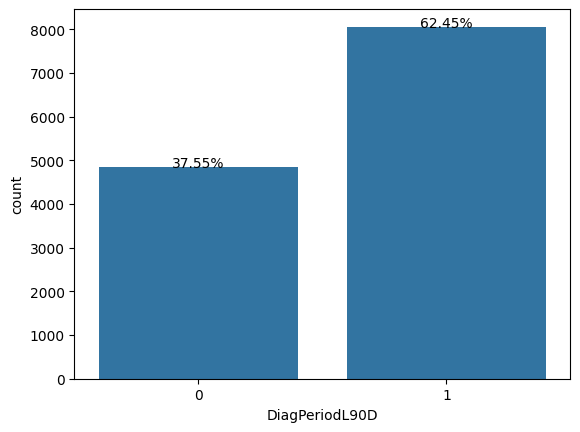

In [11]:
ax = sns.countplot(x=train['DiagPeriodL90D'])

total = len(train['DiagPeriodL90D'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            '{:.2%}'.format(height / total),
            ha="center")
plt.show()

<ipython-input-12-afdcfe9eeccd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
<ipython-input-12-afdcfe9eeccd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
<ipython-input-12-afdcfe9eeccd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
<ipython-input-12-afdcfe9eeccd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
<ipython-input-12-afdcfe9eeccd>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='sma

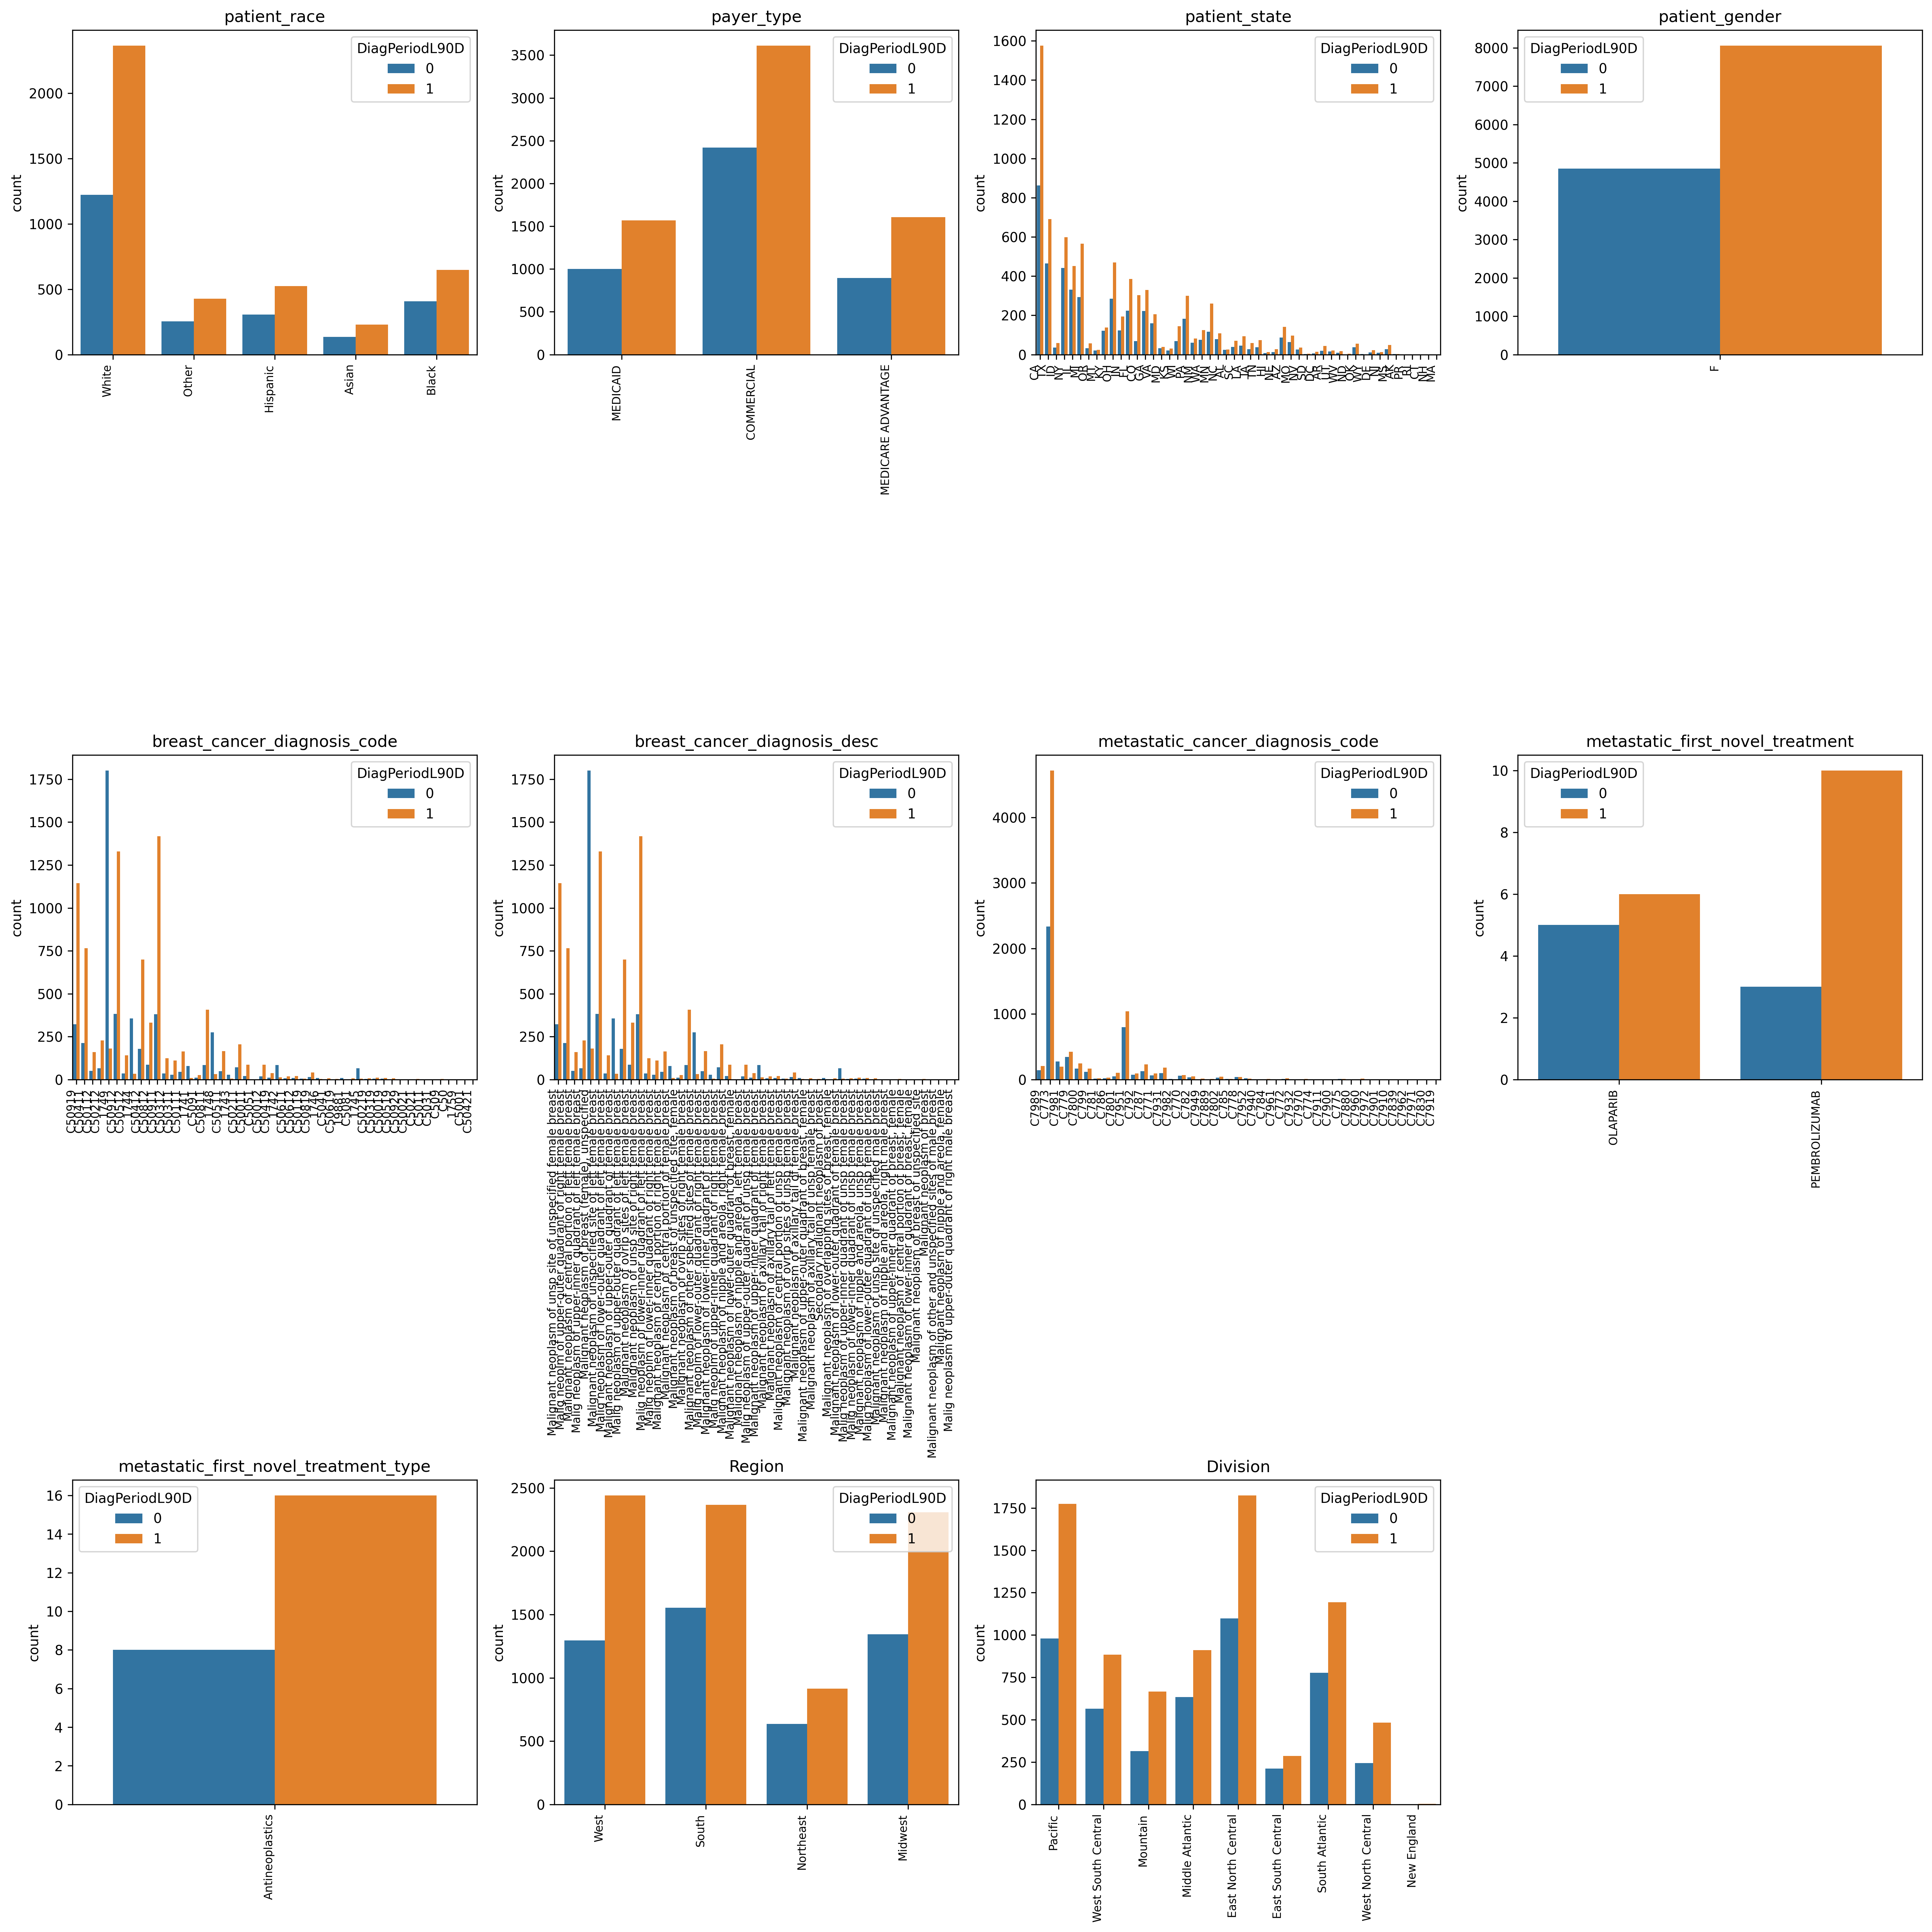

In [12]:
target = 'DiagPeriodL90D'
fig, ax = plt.subplots(3,4, figsize=(20,20), dpi=300)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
for i, col in enumerate(cat_cols):
    sns.countplot(x=train[col],hue=train[target],ax=ax[i])
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(None)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
for j in range(len(cat_cols),len(ax)):
    ax[j].axis('off')
plt.tight_layout(h_pad=0.1)
plt.show()

In [16]:
train["DiagPeriodL90D"].value_counts()

1    8060
0    4846
Name: DiagPeriodL90D, dtype: int64

In [17]:
count_class_1, count_class_0 = train['DiagPeriodL90D'].value_counts()

In [18]:
# Divide by class
df_class_0 = train[train['DiagPeriodL90D'] == 0]
df_class_1 = train[train['DiagPeriodL90D'] == 1]

Random under-sampling:
0    8060
1    8060
Name: DiagPeriodL90D, dtype: int64


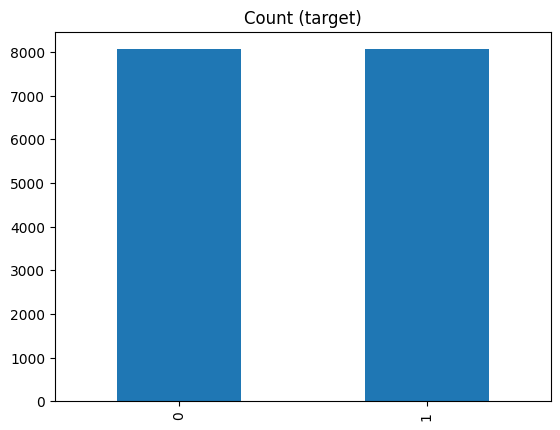

In [19]:
df_class_0_over = df_class_0.sample(count_class_1, replace=True)
df_test_over = pd.concat([df_class_0_over, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_over['DiagPeriodL90D'].value_counts())

df_test_over['DiagPeriodL90D'].value_counts().plot(kind='bar', title='Count (target)');

In [20]:
train = df_test_over
train.head()

patient_race  payer_type patient_state  patient_zip3  patient_age  \
patient_id                                                                     
852209              NaN    MEDICAID            CA           917           61   
491402         Hispanic  COMMERCIAL            CA           923           27   
935483              NaN  COMMERCIAL            TX           770           63   
906857              NaN  COMMERCIAL            CA           917           50   
527992              NaN         NaN            TX           786           57   

           patient_gender    bmi breast_cancer_diagnosis_code  \
patient_id                                                      
852209                  F    NaN                         1749   
491402                  F    NaN                       C50911   
935483                  F  30.55                         1744   
906857                  F    NaN                       C50911   
527992                  F    NaN                       C50411   

                                 breast_cancer_diagnosis_desc  \
patient_id                                                      
852209      Malignant neoplasm of breast (female), unspeci...   
491402      Malignant neoplasm of unsp site of right femal...   
935483      Malignant neoplasm of upper-outer quadrant of ...   
906857      Malignant neoplasm of unsp site of right femal...   
527992      Malig neoplm of upper-outer quadrant of right ...   

           metastatic_cancer_diagnosis_code  ...   disabled    poverty  \
patient_id                                   ...                         
852209                                 C779  ...   9.895652  10.515217   
491402                                 C773  ...  12.370492  17.627869   
935483                                 C773  ...   9.885417  18.729167   
906857                                 C773  ...   9.895652  10.515217   
527992                                C7951  ...  14.882812  11.337500   

           limited_english commute_time  health_uninsured    veteran  \
patient_id                                                             
852209           12.745652    32.530435          7.263043   3.810870   
491402            3.408333    30.925000          8.478689   7.424590   
935483           13.969792    27.925000         22.544792   3.773958   
906857           12.745652    32.530435          7.263043   3.810870   
527992            2.666667    32.218966         13.648438  10.842187   

                Ozone       PM25        N02  DiagPeriodL90D  
patient_id                                                   
852209      47.310325   9.595719  20.084231               0  
491402      51.456038   5.418150  16.240462               0  
935483      34.935395  10.153555  21.490584               0  
906857      47.310325   9.595719  20.084231               0  
527992      38.813311   7.246530   8.002836               0  

[5 rows x 82 columns]

In [13]:
class DropColumns(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        x_copy = X.copy()
        x_copy = x_copy.drop('bmi',axis=1)
        return x_copy

In [14]:
def ImputeCatCols(d):
    df = d.copy()
    for c in cat_cols:
        df[c] = df[c].fillna('None')
    return df

num_transformer = Pipeline([('imputer',SimpleImputer(strategy='mean')),
                             ('scaler',StandardScaler())])
cat_transformer = Pipeline([('imputer',FunctionTransformer(ImputeCatCols))])

preprocess = ColumnTransformer([('num',num_transformer,num_cols),
                                ('cat',cat_transformer,cat_cols)],
                                remainder='passthrough',
                                verbose_feature_names_out=False).set_output(transform='pandas')
preprocess_catboost= Pipeline([('preprocess',preprocess),
                           ('drop',DropColumns())
                          ])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [15]:
cat_transformer_2= Pipeline([('imputer',SimpleImputer(strategy='most_frequent')),
                           ('cat',CatBoostEncoder())])
num_transformer_2 = Pipeline([('imputer',SimpleImputer(strategy='most_frequent'))])
preprocess_othermodels = ColumnTransformer([('cat',cat_transformer_2,cat_cols),
                                            ('num',num_transformer_2,num_cols)
                                           ])

In [16]:
def score_model(model, label):

    print('model: {}'.format(label))
    X = train.copy()
    y = X.pop(target)

    skf = StratifiedKFold(n_splits=5,random_state=SEED, shuffle=True)

    val_predictions = np.zeros(len(train))
    score_list = []
    for fold, (trx_idx, val_idx) in enumerate(skf.split(X,y)):
        X_train = X.iloc[trx_idx]
        y_train = y.iloc[trx_idx]
        X_val   = X.iloc[val_idx]
        y_val   = y.iloc[val_idx]

        model.fit(X_train,y_train)
        y_pred_train = model.predict_proba(X_train)[:,1]
        y_pred_val   = model.predict_proba(X_val)[:,1]
        auc_train = roc_auc_score(y_train,y_pred_train)
        auc_val   = roc_auc_score(y_val,y_pred_val)

        val_predictions[val_idx] = y_pred_val
        score_list.append(auc_val)
        print(f'fold: {fold} - AUC Train: {auc_train} - AUC Val {auc_val}')

    print(f'AUC MEAN {np.mean(score_list)} - Std: {np.std(score_list)}')

    return score_list, val_predictions

In [17]:
SEED = 42


params_cat = {'learning_rate': 0.0038741132693241795,
              'iterations': 1000,
              'max_depth': 5,
              'subsample': 0.7401131867566202,
              'colsample_bylevel': 0.29684187768021997,
              'min_data_in_leaf': 47,
              'logging_level': 'Silent'}

params_lgb= {'learning_rate': 0.0015880317763720944,
             'subsample': 0.6710494933148675,
             'colsample_bytree': 0.7929648706646588,
             'num_leaves': 29,
             'verbose':-1}
params_lgb = {'learning_rate': 0.001176435844599707,
                'subsample': 0.30836269591938725,
                'colsample_bytree': 0.9876832161025921,
                'num_leaves': 500, 'bagging_freq': 1,
                'min_child_samples': 86,
                'verbose':-1}

params_xbg = {'learning_rate': 0.0010329935862538947,
              'max_depth': 6,
              'subsample': 0.5281085467708261,
              'min_child_weight': 9}

In [18]:
score_list, oof_list= pd.DataFrame(), pd.DataFrame()
models = [
           ('catBoost',make_pipeline(preprocess_catboost,
                                    CatBoostClassifier(cat_features=cat_cols,
                                                       **params_cat,
                                                       random_state=SEED))),
           ('lgbm',make_pipeline(preprocess_othermodels,
                                 LGBMClassifier(**params_lgb,
                                                random_state=SEED))),

           ('RF',make_pipeline(preprocess_othermodels,
                               RandomForestClassifier(n_estimators=200,
                                                      random_state=SEED,
                                                      min_samples_leaf=92,
                                                      max_features=1.0))),
           ('Extratrees',make_pipeline(preprocess_othermodels,
                                       ExtraTreesClassifier(n_estimators=300,
                                                           random_state=SEED,
                                                           min_samples_leaf=46,
                                                           max_features=1.0))),
           ('XGB',make_pipeline(preprocess_othermodels,
                                 XGBClassifier(**params_xbg,random_state=SEED)))


        ]
for label, model in models:
    score_list[label], oof_list[label] = score_model(model,label)

model: catBoost
fold: 0 - AUC Train: 0.8431329736086677 - AUC Val 0.8053062085902125
fold: 1 - AUC Train: 0.8430661698020585 - AUC Val 0.797703690330775
fold: 2 - AUC Train: 0.8384204446468355 - AUC Val 0.7962558929801514
fold: 3 - AUC Train: 0.8377799163611064 - AUC Val 0.8025371504223996
fold: 4 - AUC Train: 0.8413943959765263 - AUC Val 0.8078706015513166
AUC MEAN 0.8019347087749711 - Std: 0.004407158628904135
model: lgbm
fold: 0 - AUC Train: 0.841402570888614 - AUC Val 0.7941447519889488
fold: 1 - AUC Train: 0.8360920218236837 - AUC Val 0.7860111982627712
fold: 2 - AUC Train: 0.8401429007104954 - AUC Val 0.7900501783578785
fold: 3 - AUC Train: 0.8400599570477032 - AUC Val 0.803234000927
fold: 4 - AUC Train: 0.8378888211703429 - AUC Val 0.8033028217163842
AUC MEAN 0.7953485902505966 - Std: 0.006959292838015552
model: RF
fold: 0 - AUC Train: 0.8590726886777957 - AUC Val 0.7960310557417307
fold: 1 - AUC Train: 0.8496435602596212 - AUC Val 0.7877131523890736
fold: 2 - AUC Train: 0.85694

<Axes: >

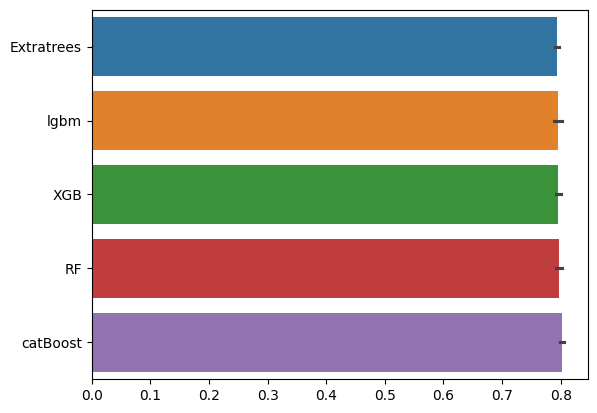

In [19]:
sns.barplot( data=score_list.reindex(score_list.mean().sort_values().index,axis=1),orient='h' )

In [20]:
w = RidgeClassifier().fit(oof_list,train.DiagPeriodL90D).coef_[0]
w

array([ 0.97712343, -0.26357224,  1.29466486, -0.2213505 ,  0.10964985])

In [21]:
voter = VotingClassifier(models, weights = w, voting = 'soft')

X = train.copy()
y = X.pop('DiagPeriodL90D')

voter.fit(X,y)

VotingClassifier(estimators=[('catBoost',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('preprocess',
                                                                ColumnTransformer(remainder='passthrough',
                                                                                  transformers=[('num',
                                                                                                 Pipeline(steps=[('imputer',
                                                                                                                  SimpleImputer()),
                                                                                                                 ('scaler',
                                                                                                                  StandardScaler())]),
                                                                                                 ['patient_zip3',
                                                                                                  'patient_age',
                                                                                                  'bmi',
                                                                                                  'population',
                                                                                                  'density',
                                                                                                  'age_median',
                                                                                                  'age_under_10',
                                                                                                  'age_10_to_19',
                                                                                                  'age_20s',
                                                                                                  'a...
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=9,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))],
                 voting='soft',
                 weights=array([ 0.97712343, -0.26357224,  1.29466486, -0.2213505 ,  0.10964985]))

In [22]:
def submit_result(voter,test):
    sub  = pd.read_csv(r'/content/sample_submission.csv')
    sub["DiagPeriodL90D"] = voter.predict_proba(test)[:, 1]
    sub.to_csv('submission.csv',index=False)

In [23]:
submit_result(voter,test)

('catBoost',
 Pipeline(steps=[('pipeline',
                  Pipeline(steps=[('preprocess',
                                   ColumnTransformer(remainder='passthrough',
                                                     transformers=[('num',
                                                                    Pipeline(steps=[('imputer',
                                                                                     SimpleImputer()),
                                                                                    ('scaler',
                                                                                     StandardScaler())]),
                                                                    ['patient_zip3',
                                                                     'patient_age',
                                                                     'bmi',
                                                                     'population',
                           